# 02 — Data Audit (Schema, Timezone & Session Coverage)

**Goal.** Before any backtest, verify that our raw data cleanly supports the strategy’s session rules:
- Timestamps parse correctly and map to **America/New_York** (NY) time.
- **Opening Range (OR)** window **09:30–10:00 (inclusive)** has all expected minutes (31 bars).
- The trading window **09:30–12:00** is complete, and both **10:22** (entry) and **12:00** (hard exit) bars exist.
- Days with gaps, duplicates, or anomalies are **excluded with a clear reason**.

**Inputs.**
- Raw 1-minute CSVs in `data/raw/`, semicolon `;` delimited, **no header**  
  Columns: `datetime;open;high;low;close;volume`  
- Config files (single source of truth):  
  - `config/strategy.yml`  → zones, SL/TP, one-trade/day  
  - `config/instruments.yml` → timezone, OR/entry/exit times, costs, data schema

**Outputs of this notebook.**
- `reports/tables/valid_days.csv` — dates that passed all checks with OR stats  
- `reports/tables/exclusion_log.csv` — dates we skipped **and why**  
- 2–3 quick visuals for coverage and OR-range distribution

> **Why this matters.** Clean coverage prevents hidden biases (like missing 10:22) and makes backtest results **reproducible** and **trustworthy**.

---


## Executive summary (run after 2.4)
- What we produce here: `valid_days.csv` (kept dates with OR stats) and `exclusion_log.csv` (skipped dates + reasons).
- Why it matters: missing 10:22/12:00 or gaps will bias the backtest; we quarantine bad days upfront.
- Quick takeaways (populate after running 2.4):
  - How many **valid** days vs **excluded** days?
  - Top 3 exclusion reasons?
  - Any year/month with unusual gaps?


## QC checklist (what “valid” means here)
- Schema matches expectations: 6 columns, delimiter and datetime format per config.
- Timestamps parse and map to **America/New_York** (or via `source_timezone`).
- OR window **09:30–10:00 inclusive** has all **31 minutes** and **non-zero** range.
- Trade window **09:30–12:00 inclusive** has **no missing** or **duplicate** minutes.
- Bars at **10:22** (entry) and **12:00** (hard exit) exist.
- Premarket excluded if `has_premarket: false`; gaps/dupes cause exclusion if enabled in policies.


###  2.1 — Imports, paths, and config preview (no data read yet)

In [1]:
# 2.1 — Imports, paths, and config preview (no data read yet)

from pathlib import Path
import pandas as pd
import yaml

# Pretty printing
pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 30)

# Project layout
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
CONFIG_DIR = ROOT / "config"
DATA_RAW_DIR = ROOT / "data" / "raw"
REPORTS_TBLS = ROOT / "reports" / "tables"
REPORTS_FIGS = ROOT / "reports" / "figures"

for d in (REPORTS_TBLS, REPORTS_FIGS):
    d.mkdir(parents=True, exist_ok=True)

def load_yaml(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

# Load configs (single source of truth)
STRATEGY = load_yaml(CONFIG_DIR / "strategy.yml")
INSTR    = load_yaml(CONFIG_DIR / "instruments.yml")

# Extract frequently used fields for a quick human check
session = INSTR.get("session", {})
data_cfg = INSTR.get("data", {})
policies = INSTR.get("policies", {})
market   = INSTR.get("market", {})
costs    = INSTR.get("costs", {})

summary = pd.DataFrame.from_dict({
    "Instrument": [market.get("instrument", "TBD")],
    "Timezone": [session.get("timezone", "America/New_York")],
    "OR Start": [session.get("or_window", {}).get("start", "09:30")],
    "OR End (inclusive)": [session.get("or_window", {}).get("end_inclusive", "10:00")],
    "Entry Time": [session.get("entry_time", "10:22")],
    "Hard Exit": [session.get("hard_exit_time", "12:00")],
    "Top Zone %": [STRATEGY.get("parameters", {}).get("zones", {}).get("top_pct", 0.35)],
    "Bottom Zone %": [STRATEGY.get("parameters", {}).get("zones", {}).get("bottom_pct", 0.35)],
    "SL (pts)": [STRATEGY.get("parameters", {}).get("risk", {}).get("stop_loss_points", 25)],
    "TP (pts)": [STRATEGY.get("parameters", {}).get("risk", {}).get("take_profit_points", 75)],
    "$/point": [market.get("point_value_usd", 80.0)],
    "Tick size": [market.get("tick_size", None)],
    "Fees/side ($)": [costs.get("fees_per_side_usd", 0.0)],
    "Slippage (pts)": [costs.get("slippage_points", 0.0)],
    "Delimiter": [data_cfg.get("delimiter", ";")],
    "Datetime fmt": [data_cfg.get("datetime_format", "%Y%m%d %H%M%S")],
    "Source TZ": [data_cfg.get("source_timezone", None)],
    "Has premarket": [data_cfg.get("has_premarket", False)],
})

print("ROOT:", ROOT)
print("CONFIG_DIR:", CONFIG_DIR)
print("DATA_RAW_DIR:", DATA_RAW_DIR)
display(summary)

print("\nPolicies snapshot:")
display(pd.Series(policies, name="value"))


ROOT: d:\Projects\OpeningRange
CONFIG_DIR: d:\Projects\OpeningRange\config
DATA_RAW_DIR: d:\Projects\OpeningRange\data\raw


,Instrument,Timezone,OR Start,OR End (inclusive),Entry Time,Hard Exit,Top Zone %,Bottom Zone %,SL (pts),TP (pts),$/point,Tick size,Fees/side ($),Slippage (pts),Delimiter,Datetime fmt,Source TZ,Has premarket
0,NSXUSD,America/New_York,09:30,10:00,10:22,12:00,0.35,0.35,25,75,80.0,0.25,2.0,0.5,;,%Y%m%d %H%M%S,None,False



Policies snapshot:


require_complete_or_window           True
require_entry_bar                    True
require_exit_bar                     True
skip_zero_or_range                   True
min_or_range_points                   0.0
skip_days_with_gaps                  True
skip_days_with_premarket_detected    True
Name: value, dtype: object

### 2.2 — File Discovery & Schema Validation

**What we do now (read this first):**

* List CSV files in `data/raw/`.
* Read a **small sample** from each file using the configured delimiter and expected schema (6 columns, no header).
* Validate that the sample rows look right:

  * `datetime` matches the configured `datetime_format`.
  * `open/high/low/close` are numeric.
  * `volume` is numeric.
* Produce a small **table** summarizing pass/fail per file and notes.
  *(No timezone mapping or session slicing yet—this is just a quick sanity check.)*

In [2]:
# 2.2 — File Discovery & Schema Validation

from pathlib import Path
from IPython.display import display
import pandas as pd

# Ensure these exist if 2.1 wasn't run in this session
try:
    ROOT
    CONFIG_DIR
    DATA_RAW_DIR
    REPORTS_TBLS
except NameError:
    ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    CONFIG_DIR = ROOT / "config"
    DATA_RAW_DIR = ROOT / "data" / "raw"
    REPORTS_TBLS = ROOT / "reports" / "tables"
    REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

# Load configs if needed (for delimiter and datetime format)
try:
    DELIM
    DATETIME_FMT
except NameError:
    import yaml
    def load_yaml(p: Path):
        with open(p, "r", encoding="utf-8") as f:
            return yaml.safe_load(f)
    INSTR = load_yaml(CONFIG_DIR / "instruments.yml")
    data_cfg = INSTR.get("data", {})
    DELIM = data_cfg.get("delimiter", ";")
    DATETIME_FMT = data_cfg.get("datetime_format", "%Y%m%d %H%M%S")

REQUIRED_COLS_COUNT = 6
EXPECTED_ORDER = ["datetime", "open", "high", "low", "close", "volume"]

files = sorted(DATA_RAW_DIR.glob("*.csv"))
if not files:
    raise FileNotFoundError(f"No CSV files found in {DATA_RAW_DIR}. Place your 2020–2023 files there.")

rows = []
for p in files:
    note = ""
    parse_ok = False
    col_count = None
    dt_ok = False
    price_ok = False
    vol_ok = False
    sample_rows = 0

    try:
        # Read a small sample to validate schema quickly
        sample = pd.read_csv(p, sep=DELIM, header=None, nrows=200, dtype=str, engine="python")
        col_count = sample.shape[1]
        sample_rows = len(sample)

        if col_count == REQUIRED_COLS_COUNT:
            sample.columns = EXPECTED_ORDER

            # Datetime check against configured format
            dt = pd.to_datetime(sample["datetime"], format=DATETIME_FMT, errors="coerce")
            dt_ok = dt.notna().mean() > 0.95  # at least 95% parse

            # Numeric checks on prices & volume
            price_cols = ["open", "high", "low", "close"]
            nums = sample[price_cols].apply(pd.to_numeric, errors="coerce")
            price_ok = (~nums.isna()).mean().mean() > 0.95

            vol = pd.to_numeric(sample["volume"], errors="coerce")
            vol_ok = vol.notna().mean() > 0.95

            parse_ok = bool(dt_ok and price_ok and vol_ok)
            note = "OK" if parse_ok else "Parsed but some fields failed (datetime and/or numeric)."
        else:
            note = f"Expected 6 columns with sep='{DELIM}', found {col_count}. Check delimiter or file."

    except Exception as e:
        note = f"Error: {type(e).__name__}: {e}"

    rows.append({
        "file": p.name,
        "sample_rows": sample_rows,
        "columns_detected": col_count,
        "datetime_format_ok": dt_ok,
        "prices_numeric_ok": price_ok,
        "volume_numeric_ok": vol_ok,
        "parse_ok": parse_ok,
        "note": note
    })

schema_report = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
display(schema_report)

# (Optional) Save the quick schema report for reference
schema_path = REPORTS_TBLS / "schema_quick_check.csv"
schema_report.to_csv(schema_path, index=False)
print("Saved quick schema check to:", schema_path)


,file,sample_rows,columns_detected,datetime_format_ok,prices_numeric_ok,volume_numeric_ok,parse_ok,note
0,DAT_ASCII_NSXUSD_M1_2020.csv,200,6,True,True,True,True,OK
1,DAT_ASCII_NSXUSD_M1_2021.csv,200,6,True,True,True,True,OK
2,DAT_ASCII_NSXUSD_M1_2022.csv,200,6,True,True,True,True,OK
3,DAT_ASCII_NSXUSD_M1_2023.csv,200,6,True,True,True,True,OK
4,DAT_ASCII_NSXUSD_M1_2024.csv,200,6,True,True,True,True,OK


Saved quick schema check to: d:\Projects\OpeningRange\reports\tables\schema_quick_check.csv


### 2.3 — Timestamp Parsing & Timezone Mapping (→ America/New\_York)

**What we do now (read this first):**

* Parse each file’s `datetime` column using the configured `datetime_format`.
* Localize/convert timestamps to **America/New\_York** using `source_timezone` from config (if `null`, assume times are already NY local).
* Check basic integrity: monotonic order, duplicate timestamps, and parsing failure rate.
* Produce a per-file **timestamp/Timezone report** for quick verification (saved to `reports/tables/timestamp_tz_report.csv`).
  *(No session slicing or OR checks yet — that’s 2.4.)*

In [3]:
# 2.3 — Timestamp Parsing & Timezone Mapping to America/New_York

from pathlib import Path
import pandas as pd
import numpy as np
import pytz

# Ensure key variables if 2.1 wasn't run in this session
try:
    ROOT, CONFIG_DIR, DATA_RAW_DIR, REPORTS_TBLS
except NameError:
    ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    CONFIG_DIR = ROOT / "config"
    DATA_RAW_DIR = ROOT / "data" / "raw"
    REPORTS_TBLS = ROOT / "reports" / "tables"
    REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

# Load configs we need
try:
    INSTR
    session
    data_cfg
except NameError:
    import yaml
    def load_yaml(p: Path):
        with open(p, "r", encoding="utf-8") as f:
            return yaml.safe_load(f)
    INSTR  = load_yaml(CONFIG_DIR / "instruments.yml")
    session = INSTR.get("session", {})
    data_cfg = INSTR.get("data", {})

TZ_MARKET   = session.get("timezone", "America/New_York")
DATETIME_FMT = data_cfg.get("datetime_format", "%Y%m%d %H%M%S")
DELIM        = data_cfg.get("delimiter", ";")
SRC_TZ_NAME  = data_cfg.get("source_timezone")  # e.g., "UTC" or None

NY = pytz.timezone(TZ_MARKET)
SRC_TZ = pytz.timezone(SRC_TZ_NAME) if SRC_TZ_NAME else None

files = sorted(DATA_RAW_DIR.glob("*.csv"))
if not files:
    raise FileNotFoundError(f"No CSV files found in {DATA_RAW_DIR}. Place your 2020–2023 files there.")

def parse_to_market_tz(dt_series: pd.Series) -> pd.DatetimeIndex:
    """
    Parse with DATETIME_FMT, then:
    - If source_timezone is set -> localize to SRC_TZ and convert to NY.
    - Else -> assume naive local times in NY and localize to NY.
    """
    idx = pd.to_datetime(dt_series, format=DATETIME_FMT, errors="coerce")
    if idx.isna().any():
        # We'll report failure rate later; still return Index for inspection
        pass
    if SRC_TZ is not None:
        idx = idx.dt.tz_localize(SRC_TZ, nonexistent='NaT', ambiguous='NaT').dt.tz_convert(NY)
    else:
        # Treat as NAIVE local NY times
        idx = idx.dt.tz_localize(NY, nonexistent='NaT', ambiguous='NaT')
    return pd.DatetimeIndex(idx)

rows = []
for p in files:
    try:
        raw = pd.read_csv(p, sep=DELIM, header=None, dtype=str)
        if raw.shape[1] != 6:
            rows.append({
                "file": p.name,
                "rows_total": len(raw),
                "parse_fail_pct": 100.0,
                "tz_mode": f"{SRC_TZ_NAME or 'assume_NY'}→{TZ_MARKET}",
                "start_local": None,
                "end_local": None,
                "is_monotonic": False,
                "duplicate_timestamps": None,
                "naive_detected": SRC_TZ_NAME is None,
                "note": f"Expected 6 columns, found {raw.shape[1]}"
            })
            continue

        raw.columns = ["datetime","open","high","low","close","volume"]
        # Parse to market tz
        idx = parse_to_market_tz(raw["datetime"])

        # Metrics
        parse_fail_pct = float(idx.isna().mean() * 100.0)
        # Drop NaT rows for monotonic/dupe checks
        valid_idx = idx[~idx.isna()]
        is_mono = valid_idx.is_monotonic_increasing
        dupes = int(valid_idx.duplicated().sum())
        start_local = valid_idx.min()
        end_local   = valid_idx.max()

        note = "OK" if parse_fail_pct < 0.5 else "High parse failure rate"

        rows.append({
            "file": p.name,
            "rows_total": len(raw),
            "parse_fail_pct": round(parse_fail_pct, 3),
            "tz_mode": f"{SRC_TZ_NAME or 'assume_NY'}→{TZ_MARKET}",
            "start_local": start_local,
            "end_local": end_local,
            "is_monotonic": bool(is_mono),
            "duplicate_timestamps": dupes,
            "naive_detected": SRC_TZ_NAME is None,
            "note": note
        })

    except Exception as e:
        rows.append({
            "file": p.name,
            "rows_total": None,
            "parse_fail_pct": None,
            "tz_mode": f"{SRC_TZ_NAME or 'assume_NY'}→{TZ_MARKET}",
            "start_local": None,
            "end_local": None,
            "is_monotonic": False,
            "duplicate_timestamps": None,
            "naive_detected": SRC_TZ_NAME is None,
            "note": f"Error: {type(e).__name__}: {e}"
        })

tz_report = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
display(tz_report)

# Save report for reference and reproducibility
out_path = REPORTS_TBLS / "timestamp_tz_report.csv"
tz_report.to_csv(out_path, index=False)
print("Saved timestamp/timezone report to:", out_path)


,file,rows_total,parse_fail_pct,tz_mode,start_local,end_local,is_monotonic,duplicate_timestamps,naive_detected,note
0,DAT_ASCII_NSXUSD_M1_2020.csv,340022,0.0,assume_NY→America/New_York,2020-01-01 18:00:00-05:00,2020-12-31 16:13:00-05:00,False,60,True,OK
1,DAT_ASCII_NSXUSD_M1_2021.csv,343006,0.0,assume_NY→America/New_York,2021-01-03 18:00:00-05:00,2021-12-31 16:13:00-05:00,False,60,True,OK
2,DAT_ASCII_NSXUSD_M1_2022.csv,342771,0.0,assume_NY→America/New_York,2022-01-02 18:00:00-05:00,2022-12-30 16:12:00-05:00,False,60,True,OK
3,DAT_ASCII_NSXUSD_M1_2023.csv,299349,0.0,assume_NY→America/New_York,2023-01-02 18:00:00-05:00,2023-12-29 16:12:00-05:00,False,60,True,OK
4,DAT_ASCII_NSXUSD_M1_2024.csv,340986,0.0,assume_NY→America/New_York,2024-01-01 18:00:00-05:00,2024-12-31 16:12:00-05:00,False,60,True,OK


Saved timestamp/timezone report to: d:\Projects\OpeningRange\reports\tables\timestamp_tz_report.csv


### 2.4 — Session Coverage & OR Window Completeness

**What we do now (read this first):**

* For **each trading day** (timestamps are already New York local), we:

  1. Slice **Opening Range (OR)** = **09:30–10:00 inclusive** and require **31 bars**.
  2. Slice **trading window** = **09:30–12:00 inclusive** and check:

     * exact **10:22** exists (entry minute),
     * exact **12:00** exists (forced exit minute),
     * **no gaps** (missing minutes) or **duplicates** in the window.
  3. Compute OR **high/low/range** and optionally exclude **tiny/zero** ranges (per config).
* We then build:

  * `valid_days.csv` (kept days + OR stats), and
  * `exclusion_log.csv` (skipped days + reasons).

In [4]:
# 2.4 — Session Coverage & OR Window Completeness

from pathlib import Path
from datetime import time, datetime
import pandas as pd
import numpy as np
import pytz

# --- Ensure key variables from previous parts (2.1/2.3) ---
try:
    ROOT, CONFIG_DIR, DATA_RAW_DIR, REPORTS_TBLS
except NameError:
    ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    CONFIG_DIR = ROOT / "config"
    DATA_RAW_DIR = ROOT / "data" / "raw"
    REPORTS_TBLS = ROOT / "reports" / "tables"
    REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

# Load config (single source of truth)
try:
    INSTR; STRATEGY
except NameError:
    import yaml
    def load_yaml(p: Path):
        with open(p, "r", encoding="utf-8") as f:
            return yaml.safe_load(f)
    INSTR = load_yaml(CONFIG_DIR / "instruments.yml")
    STRATEGY = load_yaml(CONFIG_DIR / "strategy.yml")

session   = INSTR.get("session", {})
data_cfg  = INSTR.get("data", {})
policies  = INSTR.get("policies", {})

TZ_MARKET   = session.get("timezone", "America/New_York")
NY = pytz.timezone(TZ_MARKET)

OR_START_STR   = session.get("or_window", {}).get("start", "09:30")
OR_END_STR     = session.get("or_window", {}).get("end_inclusive", "10:00")  # inclusive
ENTRY_STR      = session.get("entry_time", "10:22")
EXIT_STR       = session.get("hard_exit_time", "12:00")

REQ_OR_COMPLETE   = bool(policies.get("require_complete_or_window", True))
REQ_ENTRY_BAR     = bool(policies.get("require_entry_bar", True))
REQ_EXIT_BAR      = bool(policies.get("require_exit_bar", True))
SKIP_ZERO_OR      = bool(policies.get("skip_zero_or_range", True))
MIN_OR_RANGE_PTS  = float(policies.get("min_or_range_points", 0.0))
SKIP_GAPS         = bool(policies.get("skip_days_with_gaps", True))

DELIM        = data_cfg.get("delimiter", ";")
DATETIME_FMT = data_cfg.get("datetime_format", "%Y%m%d %H%M%S")
SRC_TZ_NAME  = data_cfg.get("source_timezone")  # None ⇒ already NY local

# Helper: read one CSV fully (schema + tz handled as in 2.3)
def read_csv_to_market(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p, sep=DELIM, header=None, dtype=str)
    if df.shape[1] != 6:
        raise ValueError(f"{p.name}: expected 6 columns, found {df.shape[1]}. Check delimiter or file.")
    df.columns = ["datetime","open","high","low","close","volume"]

    # Prices/volume to numeric
    for c in ["open","high","low","close","volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Parse & set tz
    idx = pd.to_datetime(df["datetime"], format=DATETIME_FMT, errors="coerce")
    if SRC_TZ_NAME:
        src_tz = pytz.timezone(SRC_TZ_NAME)
        idx = idx.dt.tz_localize(src_tz, nonexistent='NaT', ambiguous='NaT').dt.tz_convert(NY)
    else:
        # data already New York local (naive) -> localize
        idx = idx.dt.tz_localize(NY, nonexistent='NaT', ambiguous='NaT')

    df = df.drop(columns=["datetime"])
    df.index = pd.DatetimeIndex(idx)
    df = df[~df.index.isna()].sort_index()
    return df

# Helpers: expected counts and checks
def hhmm_to_time(s: str) -> time:
    h, m = s.split(":")
    return time(int(h), int(m))

OR_START_T = hhmm_to_time(OR_START_STR)
OR_END_T   = hhmm_to_time(OR_END_STR)
ENTRY_T    = hhmm_to_time(ENTRY_STR)
EXIT_T     = hhmm_to_time(EXIT_STR)

def expected_minute_count(t_start: time, t_end: time, inclusive=True) -> int:
    base = datetime(2000,1,1)
    a = datetime(2000,1,1, t_start.hour, t_start.minute)
    b = datetime(2000,1,1, t_end.hour,   t_end.minute)
    mins = int((b - a).total_seconds() // 60)
    return mins + 1 if inclusive else mins

EXPECTED_OR_MINUTES = expected_minute_count(OR_START_T, OR_END_T, inclusive=True)  # should be 31

def day_slice(df_day: pd.DataFrame, start_str: str, end_str: str) -> pd.DataFrame:
    # tz-aware index; between_time takes strings
    return df_day.between_time(start_str, end_str, inclusive="both")

def make_target_index(day_ts: pd.Timestamp, start_t: time, end_t: time) -> pd.DatetimeIndex:
    # Build exact minute grid for 09:30..12:00 in NY tz for a given local day
    start = NY.localize(pd.Timestamp.combine(day_ts.date(), start_t))
    end   = NY.localize(pd.Timestamp.combine(day_ts.date(), end_t))
    return pd.date_range(start=start, end=end, freq="T", tz=NY)

# Iterate all files/days, run checks, collect results
files = sorted(DATA_RAW_DIR.glob("*.csv"))
if not files:
    raise FileNotFoundError(f"No CSV files found in {DATA_RAW_DIR}.")

valid_rows = []
excl_rows = []

for p in files:
    df = read_csv_to_market(p)

    # Group by local calendar day
    for day, df_day in df.groupby(df.index.date):
        # Materialize the day slice
        day_start = NY.localize(pd.Timestamp(day))
        next_day  = day_start + pd.Timedelta(days=1)
        one = df[(df.index >= day_start) & (df.index < next_day)]

        reasons = []
        stats = {"file": p.name, "date": pd.to_datetime(day)}

        # OR 09:30–10:00 inclusive
        or_slice = day_slice(one, OR_START_STR, OR_END_STR)
        stats["or_count"] = int(len(or_slice))
        if REQ_OR_COMPLETE and stats["or_count"] != EXPECTED_OR_MINUTES:
            reasons.append(f"or_incomplete({stats['or_count']}/{EXPECTED_OR_MINUTES})")

        if len(or_slice) > 0:
            or_high = or_slice["high"].max()
            or_low  = or_slice["low"].min()
            or_range = (or_high - or_low) if pd.notnull(or_high) and pd.notnull(or_low) else np.nan
            stats["or_high"] = float(or_high) if pd.notnull(or_high) else None
            stats["or_low"]  = float(or_low)  if pd.notnull(or_low)  else None
            stats["or_range"] = float(or_range) if pd.notnull(or_range) else None
            if SKIP_ZERO_OR and (pd.isna(or_range) or or_range <= MIN_OR_RANGE_PTS):
                reasons.append(f"or_range_too_small({or_range})")
        else:
            stats.update({"or_high": None, "or_low": None, "or_range": None})

        # Trading window 09:30–12:00 inclusive
        win = day_slice(one, "09:30", EXIT_STR)
        stats["trade_count"] = int(len(win))
        tgt = make_target_index(NY.localize(pd.Timestamp(day)), hhmm_to_time("09:30"), EXIT_T)

        # Missing minutes / duplicates inside the window
        missing = tgt.difference(win.index)
        dupes = int(win.index.duplicated().sum())
        stats["expected_trade_minutes"] = int(len(tgt))
        stats["missing_minutes"] = int(len(missing))
        stats["duplicate_minutes"] = dupes

        if SKIP_GAPS and len(missing) > 0:
            reasons.append(f"gap_in_trade_window({len(missing)})")
        if dupes > 0:
            reasons.append(f"duplicate_minutes({dupes})")

        # Require 10:22 and 12:00 bars (exact minutes)
        has_1022 = any(win.index.time == ENTRY_T)
        has_1200 = any(win.index.time == EXIT_T)
        stats["has_entry_1022"] = bool(has_1022)
        stats["has_exit_1200"]  = bool(has_1200)

        if REQ_ENTRY_BAR and not has_1022:
            reasons.append("missing_entry_10:22")
        if REQ_EXIT_BAR and not has_1200:
            reasons.append("missing_exit_12:00")

        if reasons:
            stats["reasons"] = "|".join(reasons)
            excl_rows.append(stats)
        else:
            valid_rows.append(stats)

valid_days = pd.DataFrame(valid_rows).sort_values("date").reset_index(drop=True)
exclusions = pd.DataFrame(excl_rows).sort_values("date").reset_index(drop=True)

display(valid_days.head(8))
display(exclusions.head(8))

# Save outputs
valid_path = REPORTS_TBLS / "valid_days.csv"
excl_path  = REPORTS_TBLS / "exclusion_log.csv"
valid_days.to_csv(valid_path, index=False)
exclusions.to_csv(excl_path, index=False)

print(f"Saved valid days -> {valid_path}")
print(f"Saved exclusions -> {excl_path}")
print(f"Counts | valid: {len(valid_days)}  excluded: {len(exclusions)}")


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_34792\1855597202.py:105: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return pd.date_range(start=start, end=end, freq="T", tz=NY)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_34792\1855597202.py:105: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return pd.date_range(start=start, end=end, freq="T", tz=NY)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_34792\1855597202.py:105: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return pd.date_range(start=start, end=end, freq="T", tz=NY)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_34792\1855597202.py:105: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return pd.date_range(start=start, end=end, freq="T", tz=NY)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_34792\1855597202.py:105: FutureW

,file,date,or_count,or_high,or_low,or_range,trade_count,expected_trade_minutes,missing_minutes,duplicate_minutes,has_entry_1022,has_exit_1200
0,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-03,31,8822.17,8752.10,70.07,151,151,0,0,True,True
1,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-06,31,8783.99,8712.49,71.50,151,151,0,0,True,True
2,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-07,31,8859.59,8816.84,42.75,151,151,0,0,True,True
3,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-08,31,8879.50,8831.97,47.53,151,151,0,0,True,True
4,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-09,31,9003.51,8977.64,25.87,151,151,0,0,True,True
5,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-10,31,9024.64,8987.70,36.94,151,151,0,0,True,True
6,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-13,31,9020.90,8987.83,33.07,151,151,0,0,True,True
7,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-14,31,9070.32,9019.66,50.66,151,151,0,0,True,True


,file,date,or_count,or_high,or_low,or_range,trade_count,expected_trade_minutes,missing_minutes,duplicate_minutes,has_entry_1022,has_exit_1200,reasons
0,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-01,0,NaN,NaN,NaN,0,151,151,0,False,False,or_incomplete(0/31)|gap_in_trade_window(151)|m...
1,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-02,31,8829.71,8793.36,36.35,150,151,1,0,True,True,gap_in_trade_window(1)
2,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-05,0,NaN,NaN,NaN,0,151,151,0,False,False,or_incomplete(0/31)|gap_in_trade_window(151)|m...
3,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-12,0,NaN,NaN,NaN,0,151,151,0,False,False,or_incomplete(0/31)|gap_in_trade_window(151)|m...
4,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-19,0,NaN,NaN,NaN,0,151,151,0,False,False,or_incomplete(0/31)|gap_in_trade_window(151)|m...
5,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-26,0,NaN,NaN,NaN,0,151,151,0,False,False,or_incomplete(0/31)|gap_in_trade_window(151)|m...
6,DAT_ASCII_NSXUSD_M1_2020.csv,2020-02-02,0,NaN,NaN,NaN,0,151,151,0,False,False,or_incomplete(0/31)|gap_in_trade_window(151)|m...
7,DAT_ASCII_NSXUSD_M1_2020.csv,2020-02-09,0,NaN,NaN,NaN,0,151,151,0,False,False,or_incomplete(0/31)|gap_in_trade_window(151)|m...


Saved valid days -> d:\Projects\OpeningRange\reports\tables\valid_days.csv
Saved exclusions -> d:\Projects\OpeningRange\reports\tables\exclusion_log.csv
Counts | valid: 1156  excluded: 399


### 2.4A — Quick sanity checks on exclusions (optional)

We verify how many days were excluded for each reason, and inspect a specific date (e.g., 2021-01-12) to see the exact flags.


In [5]:
# Breakdown of exclusion reasons
counts = (
    exclusions["reasons"]
    .str.split("|").explode()
    .value_counts()
    .rename("count")
)
display(counts)

# Inspect a specific date (change the date string as needed)
date_to_check = "2021-01-12"   # or "2021-01-01" if you meant New Year's Day
display(exclusions[exclusions["date"] == date_to_check])


reasons
missing_exit_12:00          332
missing_entry_10:22         326
or_incomplete(0/31)         281
gap_in_trade_window(151)    268
or_incomplete(30/31)         47
gap_in_trade_window(61)      44
or_incomplete(1/31)          37
gap_in_trade_window(90)      33
gap_in_trade_window(60)      15
gap_in_trade_window(91)      12
gap_in_trade_window(1)        7
gap_in_trade_window(3)        4
gap_in_trade_window(31)       3
gap_in_trade_window(2)        2
gap_in_trade_window(150)      2
gap_in_trade_window(5)        2
gap_in_trade_window(120)      2
gap_in_trade_window(63)       1
gap_in_trade_window(7)        1
or_incomplete(21/31)          1
gap_in_trade_window(11)       1
gap_in_trade_window(4)        1
or_incomplete(26/31)          1
gap_in_trade_window(6)        1
Name: count, dtype: int64

,file,date,or_count,or_high,or_low,or_range,trade_count,expected_trade_minutes,missing_minutes,duplicate_minutes,has_entry_1022,has_exit_1200,reasons


In [6]:
# 2.4A — Audit summary snapshot (auto-generated after 2.4)
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
valid_path = REPORTS_TBLS / "valid_days.csv"
excl_path  = REPORTS_TBLS / "exclusion_log.csv"

vd = globals().get("valid_days")
if vd is None and valid_path.exists():
    vd = pd.read_csv(valid_path, parse_dates=["date"])
ex = globals().get("exclusions")
if ex is None and excl_path.exists():
    ex = pd.read_csv(excl_path, parse_dates=["date"])

if vd is None or ex is None:
    print("Run 2.4 first to build valid_days and exclusions.")
else:
    summary = {
        "valid_days": len(vd),
        "excluded_days": len(ex),
    }
    if not ex.empty:
        reason_counts = ex["reasons"].str.split("|").explode().value_counts()
        summary.update({
            "missing_entry_10:22": int(reason_counts.get("missing_entry_10:22", 0)),
            "missing_exit_12:00": int(reason_counts.get("missing_exit_12:00", 0)),
            "or_incomplete": int(reason_counts.filter(like="or_incomplete").sum()),
            "gap_in_trade_window": int(reason_counts.filter(like="gap_in_trade_window").sum()),
        })
        top5 = reason_counts.head(5).to_frame("count")
    else:
        top5 = pd.DataFrame()

    summary_ser = pd.Series(summary, name="value")
    display(summary_ser)
    if not top5.empty:
        print("Top exclusion reasons:")
        display(top5)

    out_path = REPORTS_TBLS / "data_audit_summary.csv"
    summary_ser.to_csv(out_path)
    print("Saved summary ->", out_path)


valid_days             1156
excluded_days           399
missing_entry_10:22     326
missing_exit_12:00      332
or_incomplete           367
gap_in_trade_window     399
Name: value, dtype: int64

Top exclusion reasons:


,count
reasons,
missing_exit_12:00,332
missing_entry_10:22,326
or_incomplete(0/31),281
gap_in_trade_window(151),268
or_incomplete(30/31),47


Saved summary -> d:\Projects\OpeningRange\reports\tables\data_audit_summary.csv


### 2.4B — Missing-minute distribution (excluded days)
Quick view of how many minutes are missing on excluded days. Large spikes often indicate weekend/holiday closures or data outages.


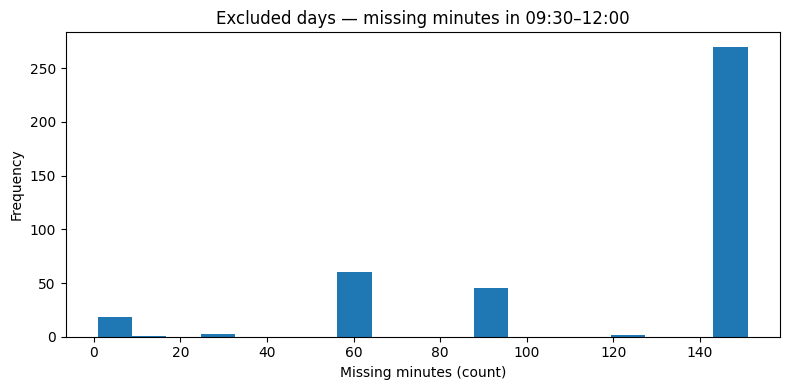

       missing_minutes
count       399.000000
mean        122.483709
std          44.556374
min           1.000000
25%          90.000000
50%         151.000000
75%         151.000000
max         151.000000


In [7]:
# 2.4B — Missing-minute histogram
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
excl_path = REPORTS_TBLS / "exclusion_log.csv"

ex = globals().get("exclusions")
if ex is None and excl_path.exists():
    ex = pd.read_csv(excl_path, parse_dates=["date"])

if ex is None or ex.empty:
    print("No exclusions to plot. Run 2.4 first.")
else:
    if "missing_minutes" not in ex.columns:
        print("missing_minutes column not found in exclusion_log.csv")
    else:
        vals = ex["missing_minutes"].fillna(0).astype(int)
        bins = max(10, min(50, int(len(vals) ** 0.5) or 10))
        plt.figure(figsize=(8,4))
        plt.hist(vals, bins=bins)
        plt.title("Excluded days — missing minutes in 09:30–12:00")
        plt.xlabel("Missing minutes (count)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        print(vals.describe().to_frame("missing_minutes"))


### 2.5 — Quick Visual Checks (coverage, OR ranges, exclusions)

#### 2.5.1 — Valid-day coverage by month/year (are there suspicious gaps?)

```markdown
**What we’re doing:**  
Turn `valid_days.csv` into a year×month grid of how many days passed our checks.  
This quickly highlights months with unusual missing coverage.

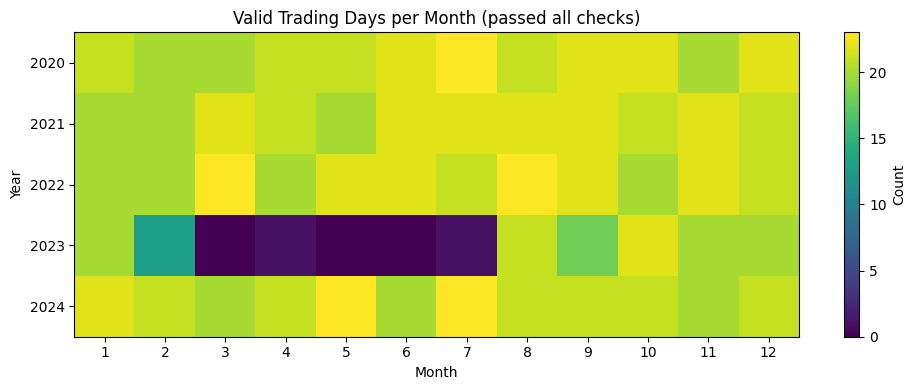

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2020,21,20,20,21,21,22,23,21,22,22,20,22
2021,20,20,22,21,20,22,22,22,22,21,22,21
2022,20,20,23,20,22,22,21,23,22,20,22,21
2023,20,13,0,1,0,0,1,21,18,22,20,20
2024,22,21,20,21,23,20,23,21,21,21,20,21


In [8]:
# 2.5.1 — Coverage heatmap

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Locate outputs even if this cell runs standalone
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
valid_path = REPORTS_TBLS / "valid_days.csv"

# Load from memory if present; else from disk
if "valid_days" in globals():
    vd = valid_days.copy()
else:
    vd = pd.read_csv(valid_path, parse_dates=["date"])

vd["year"] = vd["date"].dt.year
vd["month"] = vd["date"].dt.month

coverage = vd.groupby(["year", "month"])["date"].count().unstack(fill_value=0).sort_index()
plt.figure(figsize=(10,4))
plt.imshow(coverage.values, aspect="auto")
plt.title("Valid Trading Days per Month (passed all checks)")
plt.yticks(ticks=range(len(coverage.index)), labels=coverage.index)
plt.xticks(ticks=range(coverage.shape[1]), labels=[str(m) for m in coverage.columns])
plt.colorbar(label="Count")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

# Small numeric summary
display(coverage)


**Conclusions (2.5.1):**  
- Expect roughly ~18–23 valid days per active month.  
- Look for **very low bars** in specific months (data outages/holidays) or **entire months blank** (file missing).  
- If you see a month with unusually low counts, we’ll drill into `exclusion_log.csv` next to see why.


#### 2.5.2 — Distribution of Opening Range (OR) sizes (is the window sensible?)

```markdown
**What we’re doing:**  
Plot a histogram of **OR range (points)** for all valid days.  
We print robust stats (median, 10th/90th percentiles) to set expectations for the strategy’s fixed SL/TP.

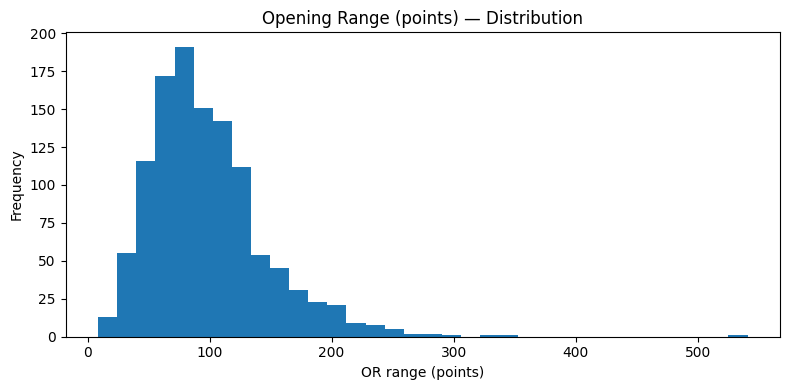

count     1156.0000
median      89.3200
p10         47.9990
p90        160.9275
min          8.6200
max        540.8870
Name: OR_range_stats, dtype: float64

In [9]:
# 2.5.2 — OR range histogram

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
valid_path = REPORTS_TBLS / "valid_days.csv"

if "valid_days" in globals():
    vd = valid_days.copy()
else:
    vd = pd.read_csv(valid_path, parse_dates=["date"])

vals = vd["or_range"].dropna().values
if len(vals) == 0:
    print("No OR ranges available. Check earlier steps.")
else:
    bins = max(10, min(50, int(np.sqrt(len(vals))) or 10))
    plt.figure(figsize=(8,4))
    plt.hist(vals, bins=bins)
    plt.title("Opening Range (points) — Distribution")
    plt.xlabel("OR range (points)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Robust stats
    stats = {
        "count": len(vals),
        "median": float(np.median(vals)),
        "p10": float(np.percentile(vals, 10)),
        "p90": float(np.percentile(vals, 90)),
        "min": float(np.min(vals)),
        "max": float(np.max(vals)),
    }
    display(pd.Series(stats, name="OR_range_stats"))


**Conclusions (2.5.2):**  
- Use the **median** and **p10/p90** to judge if SL=25, TP=75 are proportionate to typical OR sizes.  
- If OR ranges are **frequently near zero**, that hints at data issues (but we already filter zero/tiny ranges).  
- If OR ranges are typically **much smaller** than 75, the TP may be optimistic; **much larger** suggests SL/TP might be conservative.


#### 2.5.3 — Exclusions by reason (why did we skip days?)

```markdown
**What we’re doing:**  
Read `exclusion_log.csv`, break the `reasons` column into individual tags, and visualize counts.  
This explains why certain days were removed (e.g., missing 10:22, incomplete OR, gaps).

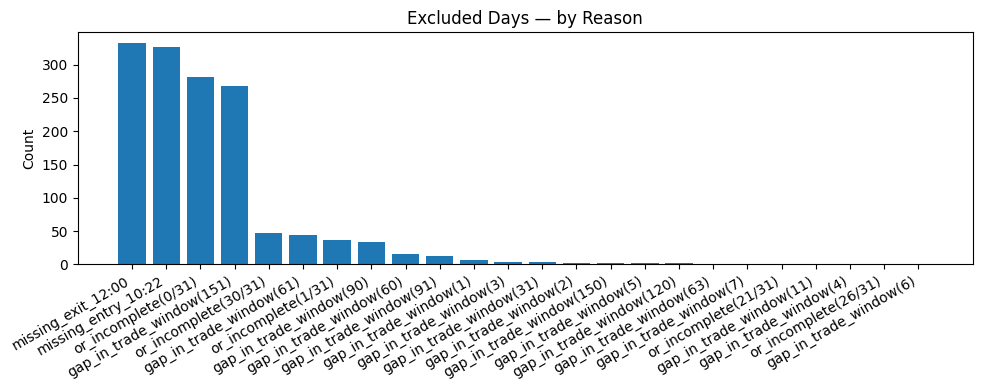

,count
reasons,
missing_exit_12:00,332
missing_entry_10:22,326
or_incomplete(0/31),281
gap_in_trade_window(151),268
or_incomplete(30/31),47
gap_in_trade_window(61),44
or_incomplete(1/31),37
gap_in_trade_window(90),33
gap_in_trade_window(60),15


In [10]:
# 2.5.3 — Exclusions by reason

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
excl_path = REPORTS_TBLS / "exclusion_log.csv"

try:
    if "exclusions" in globals():
        ex = exclusions.copy()
    else:
        ex = pd.read_csv(excl_path, parse_dates=["date"])
except FileNotFoundError:
    ex = pd.DataFrame()

if ex.empty:
    print("No exclusions recorded — great! (or check earlier steps saved the file.)")
else:
    reason_counts = (
        ex["reasons"]
        .str.split("|").explode()
        .value_counts()
    )
    plt.figure(figsize=(10,4))
    plt.bar(reason_counts.index, reason_counts.values)
    plt.title("Excluded Days — by Reason")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    display(reason_counts.to_frame("count").head(20))


**Conclusions (2.5.3):**  
- The **top reasons** should align with expectations: holidays/half-days causing **missing 09:30–12:00**, or occasional **missing 10:22/12:00**.  
- If **gaps in trade window** dominate a specific **month/year**, your provider had outages then—our audit correctly quarantined those days.


## What we learned (fill after running)
- Coverage: ____ valid days, ____ excluded; biggest gaps in ______.
- Top exclusion reasons: ______.
- Data readiness: Safe to proceed to baseline backtest? (yes/no, why).
- Next actions: backfill specific months? adjust policies? set costs/tick before backtest.


In [11]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
excl_path = ROOT / "reports" / "tables" / "exclusion_log.csv"

ex = pd.read_csv(excl_path, parse_dates=["date"])
mask_2023_Feb_to_Jul = (ex["date"].dt.year == 2023) & (ex["date"].dt.month.between(2, 7))
ex23 = ex.loc[mask_2023_Feb_to_Jul].copy()

if ex23.empty:
    print("No exclusions recorded for 2023-02..07 (double-check earlier steps saved exclusion_log.csv).")
else:
    reasons_counts = (
        ex23["reasons"].str.split("|").explode().value_counts().rename("count")
    )
    display(reasons_counts.to_frame().head(20))

    print("\nSample excluded rows (show key stats):")
    cols = ["date","file","reasons","or_count","has_entry_1022","has_exit_1200","missing_minutes","duplicate_minutes","trade_count"]
    display(ex23[cols].sort_values("date").head(12))


,count
reasons,
missing_exit_12:00,87
missing_entry_10:22,85
or_incomplete(30/31),44
gap_in_trade_window(61),43
or_incomplete(0/31),41
or_incomplete(1/31),37
gap_in_trade_window(90),33
gap_in_trade_window(151),28
gap_in_trade_window(60),14



Sample excluded rows (show key stats):


,date,file,reasons,or_count,has_entry_1022,has_exit_1200,missing_minutes,duplicate_minutes,trade_count
173,2023-02-05,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(0/31)|gap_in_trade_window(151)|m...,0,False,False,151,0,0
174,2023-02-12,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(0/31)|gap_in_trade_window(151)|m...,0,False,False,151,0,0
175,2023-02-19,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(0/31)|gap_in_trade_window(151)|m...,0,False,False,151,0,0
176,2023-02-20,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(30/31)|gap_in_trade_window(61)|m...,30,False,False,61,0,90
177,2023-02-21,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(30/31)|gap_in_trade_window(61)|m...,30,False,False,61,0,90
178,2023-02-22,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(1/31)|gap_in_trade_window(90),1,True,True,90,0,61
179,2023-02-23,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(1/31)|gap_in_trade_window(31)|mi...,1,True,False,31,0,120
180,2023-02-24,DAT_ASCII_NSXUSD_M1_2023.csv,gap_in_trade_window(63),31,True,True,63,0,88
181,2023-02-26,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(0/31)|gap_in_trade_window(151)|m...,0,False,False,151,0,0
182,2023-02-27,DAT_ASCII_NSXUSD_M1_2023.csv,or_incomplete(30/31)|gap_in_trade_window(61)|m...,30,False,False,61,0,90
